# 第五次作业「使用DQN玩儿星球大战游戏」

游戏部分借鉴了 「yueyangming」 https://github.com/yueyangming/PyTorch_homework/tree/master/homework05-1129 的代码

## 准备游戏

游戏部分代码在 [yueyangming](https://github.com/yueyangming/PyTorch_homework/tree/master/homework05-1129) 代码的基础上做了修改：

* 增加了速度参数，统一了屏幕宽高参数
* 修改了每一帧返回的数据结构

In [11]:
# import the pygame module
import pygame

# import random for random numbers!
import random

# import pygame.locals for easier access to key coordinates
from pygame.locals import *

class Player(pygame.sprite.Sprite):
    def __init__(self, width, height, speed=2):
        super(Player, self).__init__()
        self.image = pygame.image.load('assets/jet.png').convert()
        self.image.set_colorkey((255, 255, 255), RLEACCEL)
        self.rect = self.image.get_rect()
        self.speed = speed
        self.width = width
        self.height = height

    def update(self, pressed_keys):
        if pressed_keys[0]:  # Up
            self.rect.move_ip(0, -self.speed)
        if pressed_keys[1]:  # Down
            self.rect.move_ip(0, self.speed)
        if pressed_keys[2]:  # Left
            self.rect.move_ip(-self.speed, 0)
        if pressed_keys[3]:  # Right
            self.rect.move_ip(self.speed, 0)

        # Keep player on the screen
        if self.rect.left < 0:
            self.rect.left = 0
        elif self.rect.right > self.width:
            self.rect.right = self.width
        if self.rect.top <= 0:
            self.rect.top = 0
        elif self.rect.bottom >= self.height:
            self.rect.bottom = self.height

class Enemy(pygame.sprite.Sprite):
    def __init__(self, width, height, speed_min, speed_max):
        super(Enemy, self).__init__()
        self.image = pygame.image.load('assets/missile.png').convert()
        self.image.set_colorkey((255, 255, 255), RLEACCEL)
        self.rect = self.image.get_rect(
            center=(random.randint(width+20, width+100), random.randint(0, height)))
        self.speed = random.randint(round(speed_min * 100), round(speed_max * 100)) / 100

    def update(self):
        self.rect.move_ip(-self.speed, 0)
        if self.rect.right < 0:
            self.kill()


class Cloud(pygame.sprite.Sprite):
    def __init__(self, width, height, speed=2):
        super(Cloud, self).__init__()
        self.image = pygame.image.load('assets/cloud.png').convert()
        self.image.set_colorkey((0, 0, 0), RLEACCEL)
        self.rect = self.image.get_rect(center=(
            random.randint(width+20, width+100), random.randint(0, height))
        )
        self.speed = speed

    def update(self):
        self.rect.move_ip(-self.speed, 0)
        if self.rect.right < 0:
            self.kill()

class Game(object):
    def __init__(self, width = 800, height = 600, player_speed=2, cloud_speed=2, enemy_min_speed=1.0, enemy_max_speed=3.0):
        # initialize pygame
        pygame.init()
        self.width = width
        self.height = height
        self.cloud_speed = cloud_speed
        self.enemy_min_speed = enemy_min_speed
        self.enemy_max_speed = enemy_max_speed
        self.player_speed = player_speed

        # create the screen object
        # here we pass it a size of 800x600
        self.screen = pygame.display.set_mode((width, height))

        # create our 'player', right now he's just a rectangle
        self.player = Player(width, height, player_speed)

        self.background = pygame.Surface(self.screen.get_size())
        self.background.fill((135, 206, 250))

        self.enemies = pygame.sprite.Group()
        self.clouds = pygame.sprite.Group()
        self.all_sprites = pygame.sprite.Group()
        self.all_sprites.add(self.player)
        self.running = True
        self.framecount = 0

    def get_frame(self, Key_press, QuitFlag = False):
        
        if self.running:
            self.framecount += 1

            if random.random() < 0.13:
                new_enemy = Enemy(self.width, self.height, self.enemy_min_speed, self.enemy_max_speed)
                self.enemies.add(new_enemy)
                self.all_sprites.add(new_enemy)
            
            self.screen.blit(self.background, (0, 0))
            if QuitFlag == True:
                self.running = False
            self.player.update(Key_press)
            self.enemies.update()
            self.clouds.update()
            for entity in self.all_sprites:
                self.screen.blit(entity.image, entity.rect)
                
            reward = 0.01
            terminal = False

            # 撞到子弹
            if pygame.sprite.spritecollideany(self.player, self.enemies):
                reward = -1
                terminal = True
                # self.player.kill()
                # 重新开始
                for entity in self.all_sprites:
                    entity.kill()
                self.__init__(self.width, self.height, self.player_speed, self.cloud_speed, self.enemy_min_speed, self.enemy_max_speed)
            
            image_data = pygame.surfarray.array3d(self.screen)
            
            return image_data, reward, terminal


## 测试游戏

初始化游戏

In [12]:
SCREEN_WIDTH = 240
SCREEN_HEIGHT = 240

# __init__(self, width = 800, height = 600, player_speed=2, cloud_speed=2, enemy_min_speed=1.0, enemy_max_speed=3.0):
game = Game(width = SCREEN_WIDTH, height = SCREEN_HEIGHT, player_speed=8, cloud_speed=5, 
            enemy_min_speed=5.0, enemy_max_speed=10.0)

#### 封装游戏运行环境

In [13]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np

IMAGE_WIDTH = 80
IMAGE_HEIGHT = 80

def show_play(play, step=-1):
    
    fig = plt.figure()
    axe = fig.add_subplot(111)
    dat = np.zeros((IMAGE_HEIGHT, IMAGE_WIDTH))
    img = axe.imshow(dat)
    
    action = [False, False, False, False]
    stop = False

    i = 0
    while True:       
        if step > 0 and i == step:
            break
        if stop:
            break
            
        clear_output(wait = True)
            
        image, reward, game_over = game.get_frame(action, QuitFlag = False)
        # action = [False, True, False, False]  # [UP, Down, Left, Right]
        action, stop = play(i, action, image, reward, game_over)

        image = np.transpose(image, (1, 0, 2))
        img.set_data(image)
        img.autoscale()
        display(fig)
        i+=1


## 准备神经网络

In [14]:
from __future__ import print_function

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import cv2 #需要安装OpenCV的包

import random
import numpy as np
from collections import deque

创建一个多层CNN网络，接收多帧画面，输出为每个可能动作对应的Q函数值

In [15]:
class Net(nn.Module):
    def __init__(self, in_dim, n_class):
        super(Net, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, 9, stride=4, padding=4),   # 80x80 -> 20x20
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),                              # 20x20 -> 10x10
            nn.Conv2d(32, 64, 5, stride=2, padding=2),       # 10x10 -> 5x5
            nn.ReLU(True),
            nn.MaxPool2d(2, 2, padding = 1),                 # 5x5 -> 3x3
            nn.Conv2d(64, 64, 3, stride=1, padding = 1)
        )

        self.fc = nn.Sequential(
            # 64x5x5
            nn.Linear(576, 256),
            nn.Linear(256, n_class)
        )

    def forward(self, x):
        out = self.conv(x)
        out = out.view(out.size(0), -1)
#         print(out.size())
        out = self.fc(out)
        return out

将分类转为游戏操作指令

In [16]:
import math
def class2action(number, n_class=4):
    action = []
    mv = n_class - 1
    while mv >= 0:
        action.append((number >> mv) & 0x01 == 1)
        mv-=1
    return action

## test
# class2action(2)
# class2action(15)

将RGB图像转为灰度图

In [17]:
def rgb2gray(image, width, height):
    image = cv2.cvtColor(cv2.resize(image, (width, height)), cv2.COLOR_BGR2GRAY)
    _, image = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
    return image/1.0

### 游戏训练得分

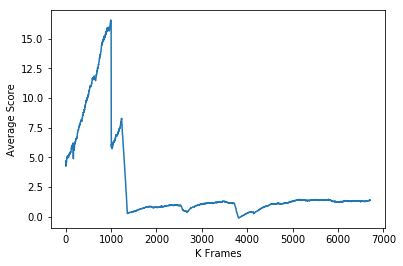

In [22]:
f = open('exp-20171215-153356/train_log.txt', 'r')

line = f.read().strip().split('\n')
values = []
for ln in line:
    segs = ln.split('/')
    values.append(float(segs[-1].split(' ')[-1]))
    
plt.figure()
plt.plot(np.arange(len(values)), values)
plt.xlabel('K Frames')
plt.ylabel('Average Score')
plt.show()

## 测试神经网络玩家

In [25]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

MEMORY = 4   # 参照的帧数
ACTION_N = 16 # 有效输出动作的个数

player = Net(MEMORY, ACTION_N)
player.load_state_dict(torch.load('exp-20171215-153356/star-parms-6710000.pkl'))

if use_cuda:
    player.cuda()

## 对游戏状态的记忆
np_st = 0
## 游戏次数
np_life = 3
## 得分
np_score = 0
np_total_score = []

    
# action, stop = play(i, action, image, reward, game_over)
def net_player(i, action, image, reward, is_over):
    global player, np_st, np_life, np_score, np_total_score
    
    np_score += reward
    
    ## 统计命数和得分
    if is_over:
        np_life -=1
        np_total_score.append(np_score)
        np_score = 0        
    
    ## 游戏结束
    if np_life == 0:
        print('\n'.join('第{}轮得分：{:.2f}'.format(i+1, np_total_score[i]) for i in range(len(np_total_score))));
        print('总得分：{:.2f}'.format(np.sum(np_total_score)))
        return [], True
    
    
    ## 输入图像
    image = rgb2gray(image, IMAGE_WIDTH, IMAGE_HEIGHT)
    if i==0:
        np_st = np.stack((image,image,image,image), axis=0)
    else:
        image = image.reshape(1, image.shape[0], image.shape[1])
        np_st = np.append(image, np_st[:3, :, :], axis=0)
        
    input = Variable(torch.FloatTensor(np_st).type(dtype)).unsqueeze(0)
    q = player(input)
    maxv, maxi = q.data.max(1)
    action = class2action(maxi[0])
        
    return action, False

第1轮得分：1.75
第2轮得分：4.91
第3轮得分：6.53
总得分：13.19


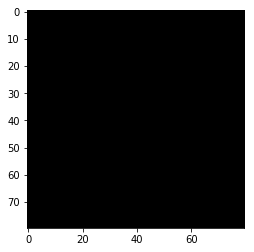

In [29]:
## 对游戏状态的记忆
np_st = 0
## 游戏次数
np_life = 3
## 得分
np_score = 0
np_total_score = []

# 运行游戏
show_play(net_player)